# Preprocess FSD50K Dataset

In [1]:
import json
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

## Read dataset files

In [2]:
# Load the metacollection file

df_metacoll = pd.read_csv(
    r"D:\datasets\FSD50K\FSD50K.metadata\collection\collection_dev.csv"
)
df_metacoll.mids = df_metacoll.mids.str.split(",")

df_metacoll.head()

,fname,labels,mids
0,64760,Electric_guitar,[/m/02sgy]
1,16399,Electric_guitar,[/m/02sgy]
2,16401,Electric_guitar,[/m/02sgy]
3,16402,Electric_guitar,[/m/02sgy]
4,16404,Electric_guitar,[/m/02sgy]


In [3]:
# Load the ontology file

ontology_filepath = "ontology.json"
with open(ontology_filepath) as f:
    mids = json.load(f)
dict_mids = {d["id"]: d for d in mids}

len(dict_mids.keys())

632

In [4]:
dict_mids

{'/m/0dgw9r': {'id': '/m/0dgw9r',
  'name': 'Human sounds',
  'description': 'Sounds produced by the human body through the actions of the individual.',
  'citation_uri': '',
  'positive_examples': [],
  'child_ids': ['/m/09l8g',
   '/m/01w250',
   '/m/09hlz4',
   '/m/0bpl036',
   '/m/0160x5',
   '/m/0k65p',
   '/m/01jg02',
   '/m/04xp5v',
   '/t/dd00012'],
  'restrictions': ['abstract']},
 '/m/09l8g': {'id': '/m/09l8g',
  'name': 'Human voice',
  'description': 'The human voice consists of sound made by a human being using the vocal folds for talking, singing, laughing, crying, screaming, etc. The human voice is specifically a part of human sound production in which the vocal folds are the primary sound source.',
  'citation_uri': 'http://en.wikipedia.org/wiki/Human_voice',
  'positive_examples': [],
  'child_ids': ['/m/09x0r',
   '/m/07p6fty',
   '/m/03qc9zr',
   '/m/02rtxlg',
   '/m/01j3sz',
   '/m/0463cq4',
   '/m/07qw_06',
   '/m/07plz5l',
   '/m/015lz1',
   '/m/02fxyj',
   '/m/07

In [5]:
# Create an id-name lookup dataframe from the ontology json

df_mids_lookup = pd.DataFrame.from_dict(
    dict_mids, orient="index", columns=["name", "child_ids"]
).reset_index()
df_mids_lookup["name"] = (
    df_mids_lookup["name"].str.replace("\s", "_", regex=True).str.lower()
)

# add all the parent mids to the lookup dataframe as a list, all the way up to the root
df_mids_exploded = (
    df_mids_lookup.explode("child_ids")
    .rename(columns={"index": "mid", "child_ids": "child_mid"})
    .reset_index(drop=True)[["mid", "child_mid"]]
)

df_mids_exploded.head()

,mid,child_mid
0,/m/0dgw9r,/m/09l8g
1,/m/0dgw9r,/m/01w250
2,/m/0dgw9r,/m/09hlz4
3,/m/0dgw9r,/m/0bpl036
4,/m/0dgw9r,/m/0160x5


In [ ]:
# convert layers dict to df where keys are col values and values are rows

row = []
for k, v in layers.items():
    for i in v:
        row.append([k, i])

df_layer_lookup = pd.DataFrame(row, columns=["layer", "mid"])

df_layer_lookup.head()

NameError: name 'layers' is not defined

In [ ]:
df_mids_lookup_layers = df_mids_exploded.join(
    df_layer_lookup.set_index("mid"), on="mid", how="left"
).rename(columns={"layer": "mid_layer"})

df_mids_lookup_layers.head()

,mid,child_mid,mid_layer
0,/m/0dgw9r,/m/09l8g,0
1,/m/0dgw9r,/m/01w250,0
2,/m/0dgw9r,/m/09hlz4,0
3,/m/0dgw9r,/m/0bpl036,0
4,/m/0dgw9r,/m/0160x5,0
...,...,...,...
1139,/m/025l19,/m/07hvw1,2
1140,/m/07hvw1,NaN,3
1141,/m/0174nj,NaN,2
1142,/m/01www,NaN,2


In [7]:
df1 = df_mids_exploded.join(
    df_mids_exploded.set_index("mid"), on="child_mid", how="left", rsuffix="_2"
)
df2 = df1.join(
    df_mids_exploded.set_index("mid"),
    on="child_mid_2",
    how="left",
    rsuffix="_3",
)
df3 = df2.join(
    df_mids_exploded.set_index("mid"),
    on="child_mid_3",
    how="left",
    rsuffix="_4",
)
df4 = df3.join(
    df_mids_exploded.set_index("mid"),
    on="child_mid_4",
    how="left",
    rsuffix="_5",
)
df5 = df4.join(
    df_mids_exploded.set_index("mid"),
    on="child_mid_5",
    how="left",
    rsuffix="_6",
)

df5.to_csv("tree_relations.csv", index=False)

In [8]:
# Create a dictionary of mid to parent mids and add it to the lookup dataframe

dict_mids_parents = (
    df_mids_exploded.groupby("child_mid")["mid"].apply(list).to_dict()
)
df_mids_lookup["parent_mids"] = df_mids_exploded["mid"].map(dict_mids_parents)

df_mids_lookup

,index,name,child_ids,parent_mids
0,/m/0dgw9r,human_sounds,"[/m/09l8g, /m/01w250, /m/09hlz4, /m/0bpl036, /...",NaN
1,/m/09l8g,human_voice,"[/m/09x0r, /m/07p6fty, /m/03qc9zr, /m/02rtxlg,...",NaN
2,/m/09x0r,speech,"[/m/05zppz, /m/02zsn, /m/0ytgt, /m/01h8n0, /m/...",NaN
3,/m/05zppz,"male_speech,_man_speaking",[],NaN
4,/m/02zsn,"female_speech,_woman_speaking",[],NaN
...,...,...,...,...
627,/m/025l19,recording,[/m/07hvw1],[/m/0838f]
628,/m/07hvw1,field_recording,[],[/m/0838f]
629,/m/0174nj,gramophone_record,[],[/m/0838f]
630,/m/01www,compact_disc,[],[/m/05kq4]


## Create a directed graph

In [9]:
# Find the first level of the ontology

first_level = set(dict_mids.keys())
for ki in dict_mids.keys():
    for kj, vd in dict_mids.items():
        if ki in vd["child_ids"]:
            first_level.remove(ki)
            break

first_level

{'/m/04rlf',
 '/m/059j3w',
 '/m/0dgw9r',
 '/m/0jbk',
 '/t/dd00041',
 '/t/dd00098',
 '/t/dd00123'}

In [10]:
# Create a directed graph from the ontology

G = nx.DiGraph()
for mid, data in dict_mids.items():
    G.add_node(mid, label=data["name"])
    for child in data["child_ids"]:
        G.add_edge(mid, child)

len(dict_mids), len(set(G.nodes())), len(G.nodes())

(632, 632, 632)

In [11]:
# Create graph layout for visualization

layers = {}
layers[0] = list(first_level)
level = list(first_level)
level_id = 0
visited = []
visited.extend(first_level)

while True:
    level_id += 1
    next_level = []
    for mid in level:
        for child in dict_mids[mid]["child_ids"]:
            if child not in visited:
                next_level.append(child)
                visited.append(child)
    if len(next_level) == 0:
        break
    layers[level_id] = next_level
    level = next_level

layers.keys()

dict_keys([0, 1, 2, 3, 4, 5])

In [13]:
# save layers as json

with open("layers.json", "w") as f:
    json.dump(layers, f)

## Visualize

### Interactive vs Non-Interactive Visualization

In [14]:
# Interactive
%matplotlib qt

In [8]:
# Non-interactive
%matplotlib inline

### Draw

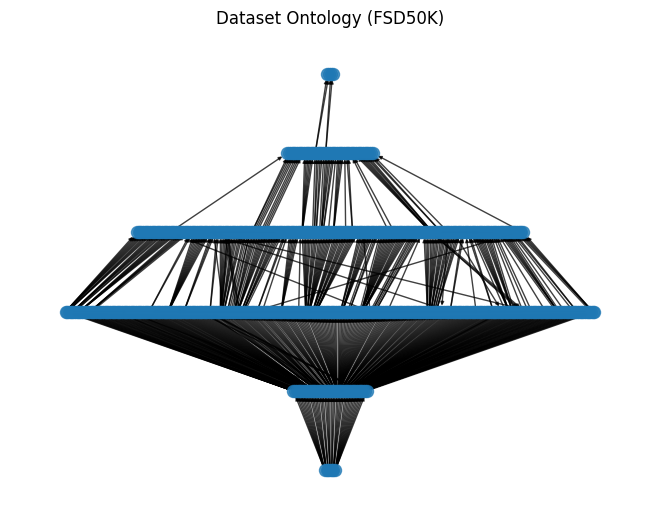

In [18]:
# Draw the graph with hierarchical layout

plt.clf()
pos = nx.multipartite_layout(G, subset_key=layers, align="horizontal")
nx.draw(
    G,
    pos,
    # labels=nx.get_node_attributes(G, "label"),
    # with_labels=True,
    node_size=75,
    font_size=10,
    font_weight="bold",
    arrowsize=5,
    width=1,
    alpha=0.75,
)

# Add labels
# for node in G.nodes():
#     x, y = pos[node]
#     label = G.nodes[node]["label"]
#     plt.text(
#         x,
#         y,
#         label[:20],
#         fontsize=8,
#         rotation=45,
#         ha="left",
#     )

plt.title("Dataset Ontology (FSD50K)")
plt.savefig("ontology_repr.png", dpi=300, bbox_inches="tight")
plt.show()

### Save graph

In [ ]:
# Save the graph to a file

with open(f"dataset_ontology.gpickle", "wb") as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

### Load graph

In [ ]:
# load the graph
import pickle

with open("dataset_ontology.gpickle", "rb") as f:
    G = pickle.load(f)

G.nodes()

NodeView(('/m/0dgw9r', '/m/09l8g', '/m/01w250', '/m/09hlz4', '/m/0bpl036', '/m/0160x5', '/m/0k65p', '/m/01jg02', '/m/04xp5v', '/t/dd00012', '/m/09x0r', '/m/07p6fty', '/m/03qc9zr', '/m/02rtxlg', '/m/01j3sz', '/m/0463cq4', '/m/07qw_06', '/m/07plz5l', '/m/015lz1', '/m/02fxyj', '/m/07s2xch', '/m/07r4k75', '/m/01j423', '/m/05zppz', '/m/02zsn', '/m/0ytgt', '/m/01h8n0', '/m/02qldy', '/m/0261r1', '/m/0brhx', '/m/07q4ntr', '/m/07rwj3x', '/m/07sr1lc', '/m/04gy_2', '/t/dd00135', '/t/dd00001', '/m/07r660_', '/m/07s04w4', '/m/07sq110', '/m/07rgt08', '/t/dd00002', '/m/07qz6j3', '/m/0l14jd', '/m/01swy6', '/m/02bk07', '/t/dd00003', '/t/dd00004', '/t/dd00005', '/t/dd00006', '/m/06bxc', '/m/01c194', '/m/079vc8', '/m/0lyf6', '/m/01b_21', '/m/01hsr_', '/m/07ppn3j', '/m/07mzm6', '/m/01d3sd', '/m/07s0dtb', '/m/07pyy8b', '/m/07q0yl5', '/m/0dl9sf8', '/m/06h7j', '/m/07qv_x_', '/m/07pbtc8', '/m/03cczk', '/m/07pdhp0', '/m/0939n_', '/m/01g90h', '/m/03q5_w', '/m/02p3nc', '/m/02_nn', '/m/025_jnm', '/m/0l15bq', '/m/

In [202]:
# create a function that returns all the parents of a given node


def get_parents(G, node, level=None):
    parents = nx.ancestors(G, node)
    if level is not None:
        parents = [p for p in parents if p in layers[level]]
    return parents


get_parents(G, "/t/dd00135", level=0)

['/m/0dgw9r']

In [185]:
df_metacoll[df_metacoll["mids"].apply(lambda x: len(x) > 1)]

,fname,labels,mids
8,64762,"Electric_guitar,Guitar","[/m/02sgy, /m/0342h]"
9,160826,"Electric_guitar,Guitar","[/m/02sgy, /m/0342h]"
44,4280,"Electric_guitar,Guitar","[/m/02sgy, /m/0342h]"
58,5312,"Electric_guitar,Bass_guitar","[/m/02sgy, /m/018vs]"
65,64711,"Electric_guitar,Guitar","[/m/02sgy, /m/0342h]"
...,...,...,...
40910,204331,"Goose,Honk","[/m/0dbvp, /m/07qwf61]"
40913,204335,"Goose,Honk","[/m/0dbvp, /m/07qwf61]"
40915,204337,"Goose,Honk","[/m/0dbvp, /m/07qwf61]"
40920,249943,"Duck,Quack","[/m/09ddx, /m/07qdb04]"
